In [1]:
import numpy as np
import pandas as pd
import graphviz
import matplotlib
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import preprocessing
from sklearn import tree
from sklearn import linear_model

# Reading the contents of the iris dataset for testing purposes.
data_set = datasets.load_iris()
np.set_printoptions(threshold=np.inf)
# full_data = np.column_stack((data_set.data, data_set.target))

# Number of perturbed samples to be generated.
n = 10000
# Number of bins for the histograms of continous attributes.
num_bins = 25

In [2]:
# Compute means and standard deviations of all features for
# later use.
means_data = np.mean(data_set.data, axis=0)
std_dev_data = np.std(data_set.data, axis=0)
print("Feature\t\t\tMean\t\t\tStd. Dev.")
for j in range(0, len(data_set.feature_names)):
    print(data_set.feature_names[j], "\t", means_data[j], "\t",
          std_dev_data[j])

Feature			Mean			Std. Dev.
sepal length (cm) 	 5.843333333333335 	 0.8253012917851409
sepal width (cm) 	 3.057333333333334 	 0.43441096773549437
petal length (cm) 	 3.7580000000000027 	 1.7594040657753032
petal width (cm) 	 1.199333333333334 	 0.7596926279021594


In [3]:
# Fitting a decision tree model to the iris dataset.
data_norm = preprocessing.scale(data_set.data)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(data_norm, data_set.target)
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=data_set.feature_names,
                                class_names=data_set.target_names,
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
# graph.render("iris")
# graph

In [4]:
####################################################################
# Functions used to generate perturbed samples and compute
# LIME weights.


def discrete_bucketize(np_vector):
    """
    Estimates histogram buckets for a discrete valued dataset.

    Input is the vector, np_vector, of discrete values that is to
    be bucketized.
    Outputs are two vectors. The first, named values, contains the
    normalized version of the unique values found in np_vector.
    It is normalized to mean zero and unit variance.
    The second output vector, named multinom_rand, contains the
    multinomial probability distribution for the elements of the
    values vector.
    """

    values, freqs = np.unique(np_vector, return_counts=True)
    freqs = freqs/np.sum(freqs)
    values = values.astype(float)
    values = preprocessing.scale(values)
    multinom_rand = np.random.multinomial(n, freqs, 1)[0]
    return(values, multinom_rand)


def continuous_bucketize(num_bins, np_vector):
    """
    Estimates histogram buckets for a continous valued dataset.

    Inputs are the desired number of bins for the histogram,
    num_bins, and np_vector, the vector of continous values that are
    to be bucketized.
    Outputs are two vectors. The first, named h_bins, is a vector of
    length num_bins + 1 that lists the values corresponding to the
    bin edges in the histogram, after they are normalized to mean
    zero and unit variance. The second output vector, named freqs,
    contains the probabilities that a randomly generated element will
    belong in each of the histogram's bins.
    """

    np_vector = preprocessing.scale(np_vector)
    freqs, h_bins = np.histogramdd(np_vector, bins=num_bins)
    freqs = freqs/np.sum(freqs)
    h_bins = np.asarray(h_bins[0])
    return(h_bins, freqs)


def discrete_rand_samples(n, values, multinom_rand):
    """
    Generates random values with multinomial probability distrib.

    Inputs are n, the number of random numbers that are to be
    generated, the vector values that lists all possible values that
    n can have, and multinom_rand which contains the multinomial
    probability distribution that corresponds to each element in the
    values vector. Output is the vector rand that contains n numbers
    chosen at random, with replacement, from the elements in the
    values vector, following the multinomial probability distribution
    that was provided.
    """

    rand = np.zeros(n)
    k = 0
    for j in range(0, len(values)):
        rand[k:k+multinom_rand[j]] = values[j]
        k = k + multinom_rand[j]
    return(rand)


def continuous_rand_samples(n, bins, freqs):
    """
    Generates random values with distribution provided as input.

    Inputs are n, the number of random numbers that are to be
    generated, the vector bins that lists the values the bin edges
    of the histogram, and the vector freqs that lists the probability
    that a value that is randomly generated will be contained by the
    corresponding histogram bin. Each random number that is generated
    is chosen from within a uniform probability distribution with end
    values equal to those of a given histogram bin. Output is the
    vector tot_samples that contains n random elements chosen as
    described above.
    """

    tot_samples = np.zeros(1)
    samples_bins = np.random.multinomial(n, freqs, 1)
    for j in range(0, len(freqs)):
        samples = np.random.uniform(bins[j], bins[j+1],
                                    samples_bins[0][j])
        tot_samples = np.hstack((tot_samples, samples))
    tot_samples = tot_samples[1:, ]
    return(tot_samples)


def lime_fit(x, x_class, perturbed_samples, class_perturb_samples):
    """
    Computes LIME linear model coefficients.

    Inputs are:
    - x, the instance from the original ML model we are trying to
      explain.
    - x_class, the classification assigned to x by the original ML
      model.
    - perturbed_samples which are the random perturbations of inputs
      that were generated.
    - class_perturb_samples which are the classifications assigned to
      each of the perturbations by the original ML model.
    Outputs are the coefficients for the LIME linear model,
    reg.coef_, and the LIME weights, l_weights.
    """

    # Compute LIME weights.
    sigma = np.var(np.sum((perturbed_samples - x)**2, axis=1))
    l_weights = np.exp(-np.sum((perturbed_samples - x)**2, axis=1) /
                       sigma)

    # We identify the correct class for the instance we wish to
    # interpret, make that class one and all others become
    # class zero.
    lime_class = class_perturb_samples == x_class
    lime_class = lime_class.astype(int)

    # Multiply the LIME weights by the perturbed samples and the
    # original ML model's output.
    perturb_weighted = (perturbed_samples.T * l_weights).T
    class_weighted = class_perturb_samples * l_weights

    # Using the perturbed samples and the above classification, we fit
    # the LIME linear model using LASSO.
    # reg = linear_model.LassoCV(eps=0.001, n_alphas=100, cv=5)
    reg = linear_model.Lasso(alpha=0.01)
    reg.fit(perturb_weighted, class_weighted)
    return(reg.coef_, reg.intercept_, l_weights)

#####################################################################

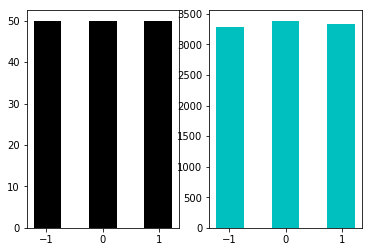

In [5]:
# This is just a test of the discrete bucketizing and random sample
# generation. Not really necessary for the example.

# Bucketizing discrete values from classifications of the original
# data, and generating a random sample of size n.
values, multinom_rand = discrete_bucketize(data_set.target)
output = discrete_rand_samples(n, values, multinom_rand)
values = preprocessing.scale(data_set.target.astype(float))

# Visually comparing the normalized distribution of classifications
# for the generated random sample.
fig, ax = plt.subplots(1, 2)
ax[0].hist(values, bins=5, color="k")
ax[1].hist(output, bins=5, color="c")
plt.show()

In [6]:
# Bucketizing each attribute from the Iris dataset and
# generating perturbed samples with the same distribution.
perturbed_samples = np.zeros(n)
for j in range(0, data_set.data.shape[1]):
    array = data_set.data[:, j]
    h_bins, freqs = continuous_bucketize(num_bins, array)
    output = continuous_rand_samples(n, h_bins, freqs)
    perturbed_samples = np.vstack((perturbed_samples, output))
perturbed_samples = np.transpose(perturbed_samples[1:, ])


Iris dataset:



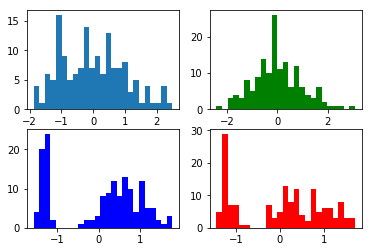


Perturbed samples:



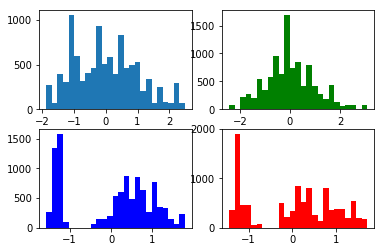

In [7]:
# Plotting the histograms for the normalized Iris dataset
# and for the perturbed samples to make sure they have
# similar distributions.

# Normalized iris dataset
print("\nIris dataset:\n")
fig, ax = plt.subplots(2, 2)
ax[0, 0].hist(data_norm[:, 0], bins=num_bins)
ax[0, 1].hist(data_norm[:, 1], bins=num_bins, color="g")
ax[1, 0].hist(data_norm[:, 2], bins=num_bins, color="b")
ax[1, 1].hist(data_norm[:, 3], bins=num_bins, color="r")
plt.show()

# Perturbed samples
print("\nPerturbed samples:\n")
fig, ax = plt.subplots(2, 2)
ax[0, 0].hist(perturbed_samples[:, 0], bins=num_bins)
ax[0, 1].hist(perturbed_samples[:, 1], bins=num_bins, color="g")
ax[1, 0].hist(perturbed_samples[:, 2], bins=num_bins, color="b")
ax[1, 1].hist(perturbed_samples[:, 3], bins=num_bins, color="r")
plt.show()

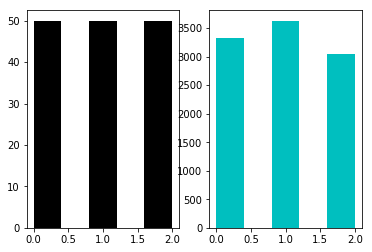

In [8]:
# Once perturbed samples have been generated, the line of code below
# uses the decision tree we fitted earlier, to get a predicted
# classification for each of our perturbed samples.
class_perturb_samples = clf.predict(perturbed_samples)

# Plotting histograms of classes for Iris dataset and perturbed
# samples, after classification by the decision tree.
fig, ax = plt.subplots(1, 2)
ax[0].hist(data_set.target, bins=5, color="k")
ax[1].hist(class_perturb_samples, bins=5, color="c")
plt.show()

In [9]:
# From the training dataset for the ML model, we select an input
# instance at random so that we can then use LIME to explain its
# output. Perturbed samples that were classifed the same as
# selected instance are True (1), those that were not are
# classified as False (0)
inst_num = np.round(np.random.uniform(0, data_set.data.shape[0], 1))
inst_num = inst_num[0].astype(int)
x = data_norm[inst_num, :]
x_class = data_set.target[inst_num]

In [10]:
# We now fit the LIME linear model to get the coefficients for
# the interpretation.
lime_beta, lime_intercept, lime_weights = lime_fit(x,
                                                   x_class,
                                                   perturbed_samples,
                                                   class_perturb_samples)

In [11]:
# Print output of LIME.
print("Instance to be interpreted:\n")
for j in range(0, len(lime_beta)):
    print("Feature: ", data_set.feature_names[j], "\tvalue: ",
          data_set.data[inst_num, j], "\tnormalized value: ",
          data_norm[inst_num, j])
print("Intercept: ", lime_intercept)
print("Classification: ",
      data_set.target_names[data_set.target[inst_num]],
      data_set.target[inst_num])
print("\nSignificant coefficients from LIME adjusted linear model:")
for j in range(0, len(lime_beta)):
    if(lime_beta[j] != 0):
        print("Feature: ", data_set.feature_names[j],
              "\tCoefficient: ", lime_beta[j])

Instance to be interpreted:

Feature:  sepal length (cm) 	value:  4.7 	normalized value:  -1.3853526520724144
Feature:  sepal width (cm) 	value:  3.2 	normalized value:  0.3284140531956675
Feature:  petal length (cm) 	value:  1.3 	normalized value:  -1.3970639535363667
Feature:  petal width (cm) 	value:  0.2 	normalized value:  -1.3154442950077407
Intercept:  0.8444977511426476
Classification:  setosa 0

Significant coefficients from LIME adjusted linear model:
Feature:  petal length (cm) 	Coefficient:  0.13140127819676703
Feature:  petal width (cm) 	Coefficient:  0.5556855558208003


In [12]:
# For visualization we separate perturbed samples classified
# by the decision tree as in-class, from those classified
# out-of-class.
full_data = np.column_stack((perturbed_samples,
                             class_perturb_samples))
in_class_data = full_data[full_data[:, 4] ==
                          data_set.target[inst_num]]
out_class_data = full_data[full_data[:, 4] !=
                           data_set.target[inst_num]]

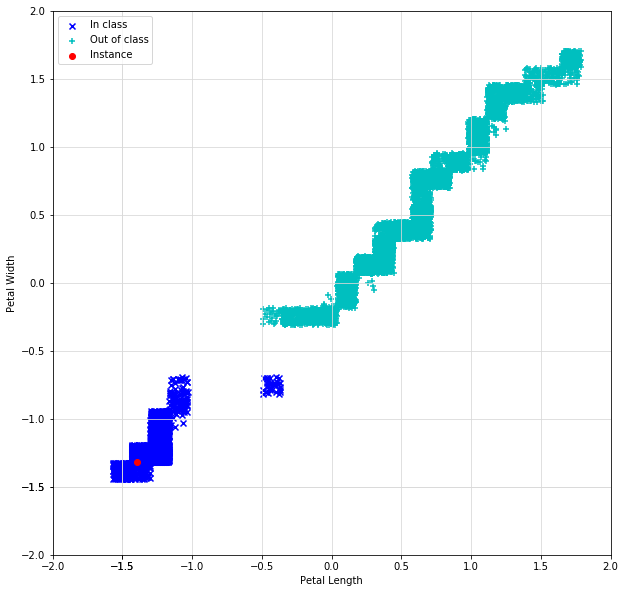

In [13]:
# Scatter plot in-class and out-of-class perturbed sampels, and the
# instance to be explained, on the petal length - petal width plane.
plt.rcParams['figure.figsize'] = [10.0, 10.0]
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(in_class_data[:, 2], in_class_data[:, 3], marker='x',
           c='b', label='In class')
ax.scatter(out_class_data[:, 2], out_class_data[:, 3], marker='+',
           c='c', label='Out of class')
ax.scatter(data_norm[inst_num, 2], data_norm[inst_num, 3],
           marker='o', c='r', label='Instance')

ticksx = ax.set_xticks([-2, -1.5, -1, -1.5, -0.5, 0, 0.5, 1, 1.5, 2])
ticksy = ax.set_yticks([-2, -1.5, -1, -1.5, -0.5, 0, 0.5, 1, 1.5, 2])
plt.grid(b=True, which='both', color='0.85', linestyle='-')
ax.set_xlabel('Petal Length')
ax.set_ylabel('Petal Width')
plt.legend(loc='upper left')

In [14]:
# Compute all LIME regression values for all perturbed samples
# and for the instance to be explained.
zero_class_reg = full_data[full_data[:, 4] == 0]
zero_class_reg = (lime_beta[2]*zero_class_reg[:, 2] +
                  lime_beta[3]*zero_class_reg[:, 3] + lime_intercept)
one_class_reg = full_data[full_data[:, 4] == 1]
one_class_reg = (lime_beta[2]*one_class_reg[:, 2] +
                 lime_beta[3]*one_class_reg[:, 3] + lime_intercept)
two_class_reg = full_data[full_data[:, 4] == 2]
two_class_reg = (lime_beta[2]*two_class_reg[:, 2] +
                 lime_beta[3]*two_class_reg[:, 3] + lime_intercept)

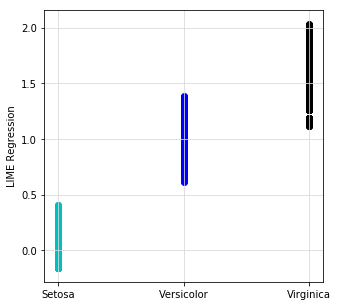

In [15]:
# Plot all LIME regression values for perturbed samples
# against their classificaton by the decision tree.
plt.rcParams['figure.figsize'] = [5.0, 5.0]
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(np.zeros(len(zero_class_reg)), zero_class_reg,
           marker='o', c='c')
ax.scatter(np.zeros(len(one_class_reg))+1, one_class_reg,
           marker='o', c='b')
ax.scatter(np.zeros(len(two_class_reg))+2, two_class_reg,
           marker='o', c='k')

ticksx = ax.set_xticks([0, 1, 2])
labelsx = ax.set_xticklabels(['Setosa', 'Versicolor', 'Virginica'])
ax.set_ylabel('LIME Regression')
plt.grid(b=True, which='both', color='0.85', linestyle='-')